### Standard Bioinformatics Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Deterministic_Annealing import DA
import utils
from importlib import reload

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.cluster import KMeans

import constrained_utils

In [3]:
# Load the dataset
data = np.load("Dataset/microarray_data.npy")

# Check its properties
print(f"Shape: {data.shape}, Type: {type(data)}")

Shape: (53, 27, 7), Type: <class 'numpy.ndarray'>


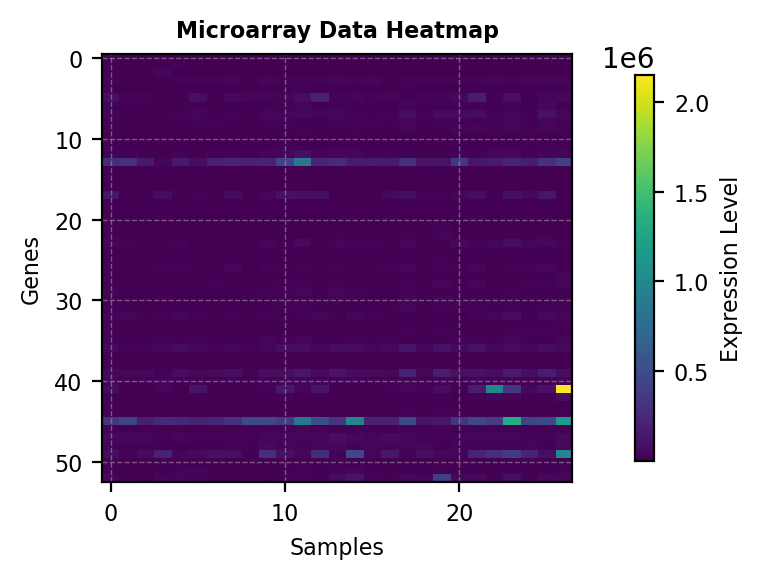

In [4]:
# Set a larger figure size and high DPI for better resolution
plt.figure(figsize=(4, 3), dpi=200)

# Use 'nearest' interpolation for a sharper image
ind = 0
plt.imshow(data[:,:,ind], aspect='auto', cmap='viridis', interpolation='nearest')

# Add a colorbar with better padding
cbar = plt.colorbar(pad=0.1, shrink=0.9)  # Shrinks the colorbar to 70% of its default size
cbar.set_label("Expression Level", fontsize=8)
cbar.ax.tick_params(labelsize=8)  # Reduce tick label size

# Label axes with larger font size
plt.xlabel("Samples", fontsize=8)
plt.ylabel("Genes", fontsize=8)
plt.title("Microarray Data Heatmap", fontsize=8, fontweight='bold')

# Improve tick visibility
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Add a grid for better readability
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.5)

# Show the figure with tight layout
plt.tight_layout()
plt.show()

### Unconstrained ONMF Results

In [5]:
# Given parameters
pert = 1e-10
m = 3
beta_final = 50
alpha = 1.2
scaler = MinMaxScaler(feature_range=(1, 10))

# Assume `data` is the (53, 27, 7) matrix provided
N, K, T = data.shape  # Extract dimensions

# Initialize storage
clustering_costs = []  # Store costs for each time instance
H_matrices = []        # Store H matrices for each time instance
Py_list = []           # Store the list of assigment arrays

# Iterate over each time instance
for find in range(T):
    Xa = data[:, :, find]  # Extract data matrix at time 'find'
    Xa_n = scaler.fit_transform(Xa)

    # Step 1: Perform clustering (unconstrained)
    Ya_2, Pa = constrained_utils.clustering(Xa_n, m, pert, beta_final, alpha)
    # Ya = scaler.inverse_transform(Ya_2)   # Convert back to original scale
    Ya = Ya_2
    Pa_bin = constrained_utils.closest_binary_matrix(Pa)

    # Step 2: Compute clustering cost
    D = constrained_utils.Clustering_Cost(Xa_n, Ya, Pa_bin)
    clustering_costs.append(D)  # Store the cost

    # Step 3: Compute permutation matrix and rearrange Pa and Ya
    Pi = constrained_utils.get_permutation_matrix(Pa_bin)
    Pa_bin, Ya = Pa_bin @ Pi, Pi.T @ Ya

    # Step 4: Compute H matrix
    H = H = constrained_utils.update_P(Pa_bin, Xa_n, Ya)
    H_matrices.append(H)  # Store H matrix

    # Step 5: Compute assignment vecors
    Py = np.sum(Pa_bin/N, axis = 0)
    Py_list.append(Py)

# Convert lists to numpy arrays for easy indexing
clustering_costs = np.array(clustering_costs)
H_matrices = np.array(H_matrices)
Py_array = np.array(Py_list)

# Print results
print("Clustering Costs for Each Time Step:\n", clustering_costs)
print("Shape of Stored H Matrices:", H_matrices.shape)  
print("Shape of Stored Py Vectors:", Py_array.shape)  


Clustering Costs for Each Time Step:
 [13.78833617 12.17730578 22.03975242 16.35213676 23.47895875 19.86747998
 17.12657124]
Shape of Stored H Matrices: (7, 53, 3)
Shape of Stored Py Vectors: (7, 3)


### Plots for Unconstrained ONMF

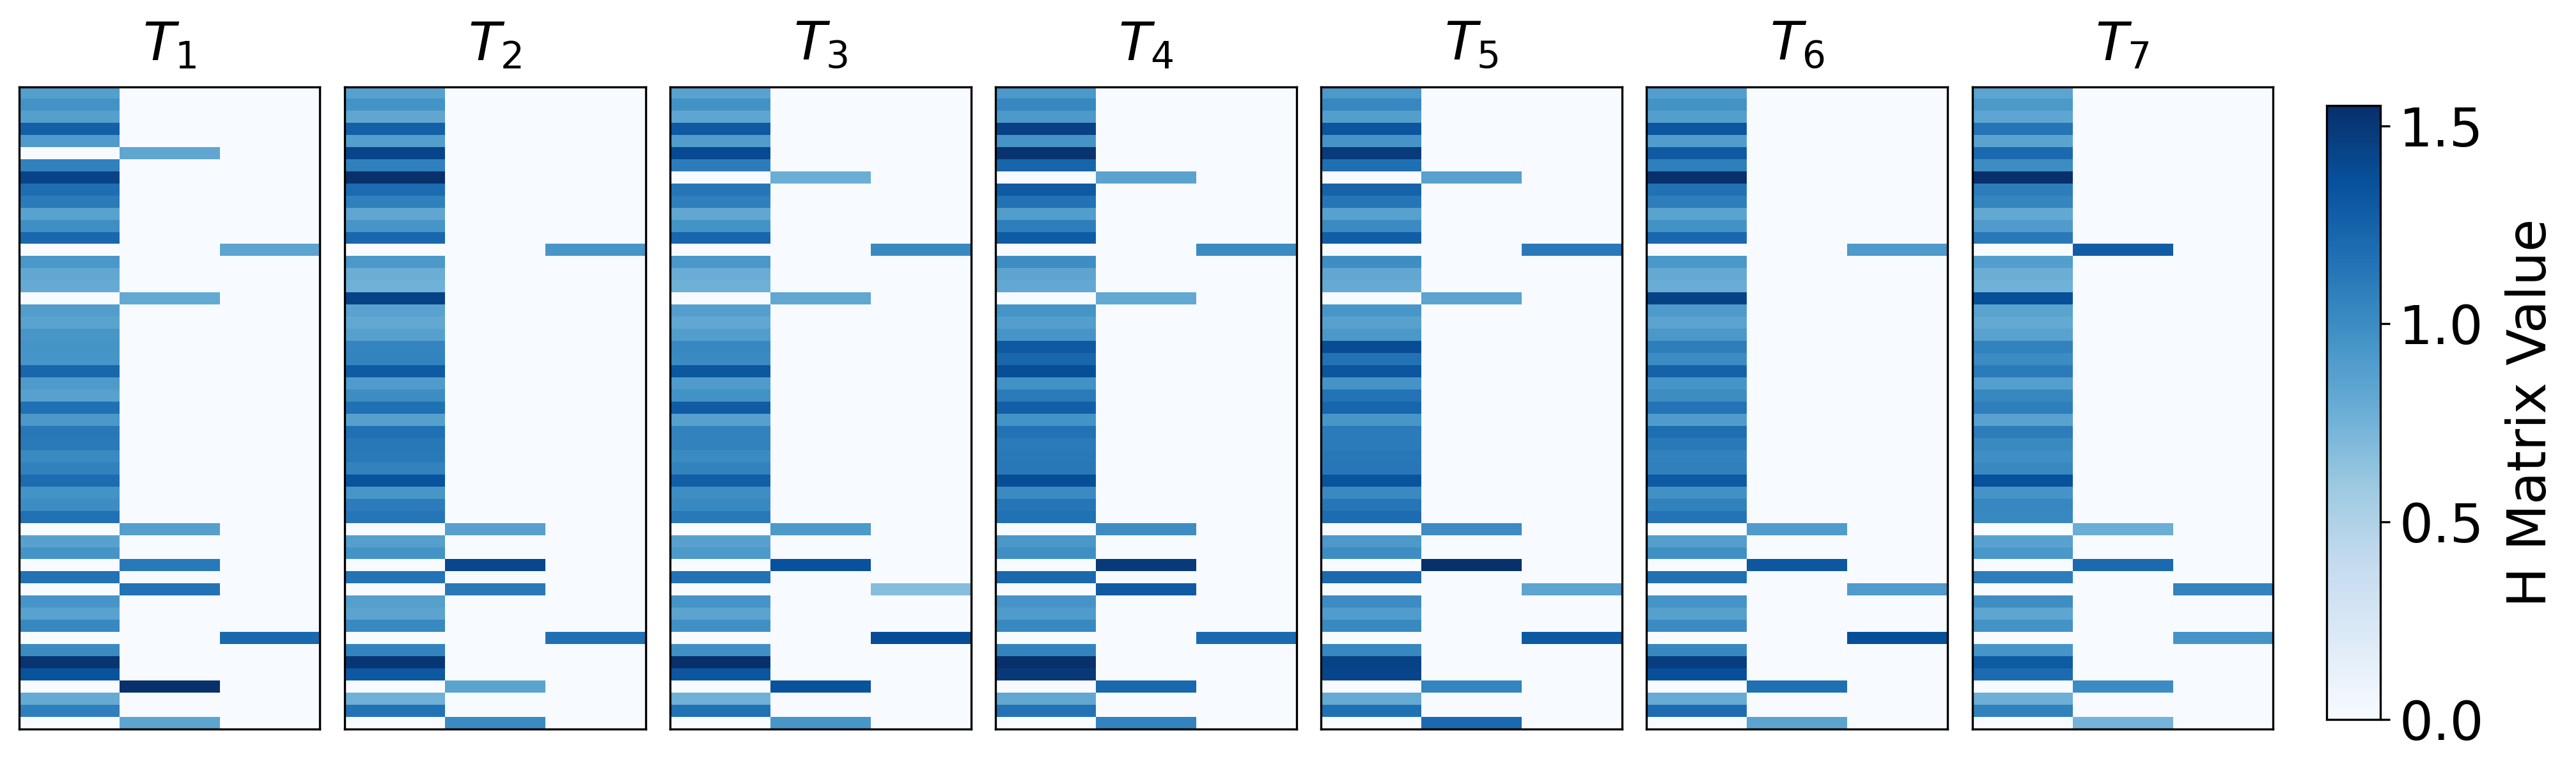

In [6]:
# Set up 1x7 subplots
fig, axes = plt.subplots(1, 7, figsize=(14, 4), dpi=300)

# Store images for color bar scaling
ims = []  

# Iterate through each constrained H matrix and plot it
for i in range(7):
    ax = axes[i]
    im = ax.imshow(H_matrices[i], cmap="Blues", aspect="auto", interpolation="nearest")
    ims.append(im)  # Store for color bar

    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False)

    # Add title for each subplot (T1, T2, ..., T7)
    ax.set_title(r"$\mathit{T_" + str(i+1) + "}$", fontsize=20, fontweight='bold', style='italic', pad=10)

# Adjust layout for better spacing
plt.tight_layout()

# Add a smaller color bar outside
fig.subplots_adjust(right=0.85)  # Make space for the color bar
cbar_ax = fig.add_axes([0.87, 0.05, 0.02, 0.8])  # Smaller and centered color bar
cbar = plt.colorbar(ims[-1], cax=cbar_ax)
cbar.set_label("H Matrix Value", fontsize=20, labelpad=8)
cbar.ax.tick_params(labelsize=20)

# Save the figure (optional)
plt.savefig("H_matrices_plot.png", dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

### Constrained ONMF Results

In [20]:
ind = -1
K = 3
Xs = data[:,:,ind].T
Xa = data[:,:,ind]

# Step 1: Normalize the data using StandardScaler
scaler = MinMaxScaler(feature_range=(1, 10))
# scaler = RobustScaler()
# scaler = StandardScaler()
Xa_n = scaler.fit_transform(Xa)

In [21]:
Ya_n_c_2, Pa_n_c_bin = constrained_utils.solve_constrained_clustering(Xa_n, m=3, C=0.35, beta_init=0.001, beta_factor=1.2)
# Transform cluster centers back to original scale
Ya_n_c = Ya_n_c_2
# Ya_n_c = scaler.inverse_transform(Ya_n_c_2)

Iteration 1: Solving for beta = 0.001
Iteration 2: Solving for beta = 0.0012
Iteration 3: Solving for beta = 0.0014399999999999999
Iteration 4: Solving for beta = 0.0017279999999999997
Iteration 5: Solving for beta = 0.0020735999999999997
Iteration 6: Solving for beta = 0.0024883199999999996
Iteration 7: Solving for beta = 0.0029859839999999993
Iteration 8: Solving for beta = 0.003583180799999999
Iteration 9: Solving for beta = 0.0042998169599999985
Iteration 10: Solving for beta = 0.005159780351999998
Iteration 11: Solving for beta = 0.0061917364223999976
Iteration 12: Solving for beta = 0.007430083706879997
Iteration 13: Solving for beta = 0.008916100448255996
Iteration 14: Solving for beta = 0.010699320537907194
Iteration 15: Solving for beta = 0.012839184645488633
Iteration 16: Solving for beta = 0.01540702157458636
Iteration 17: Solving for beta = 0.01848842588950363
Iteration 18: Solving for beta = 0.022186111067404354
Iteration 19: Solving for beta = 0.026623333280885224
Iterati

In [22]:
H = constrained_utils.update_P(Pa_n_c_bin, Xa_n, Ya_n_c)

In [25]:
np.sum(Pa_n_c_bin/N, axis=0)

array([0.35849057, 0.33962264, 0.30188679])

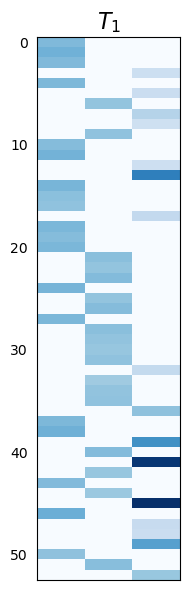

In [26]:
# Set figure size and aspect ratio
fig, ax = plt.subplots(figsize=(2, 6), dpi=100)  # Adjust width & height

# Display the heatmap
im = ax.imshow(H, cmap="Blues", aspect="auto", interpolation="nearest")

# Remove x-axis labels and ticks
ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params(left=False)

# Add a title with italic styling
ax.set_title(r"$\mathit{T_1}$", fontsize=16, fontweight='bold', style='italic')

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

In [7]:
np.random.seed(42)

# Assume `data` is the (53, 27, 7) matrix provided
N, K, T = data.shape  # Extract dimensions

# Initialize storage
clustering_costs_constrained = []  # Store constrained clustering costs
H_matrices_constrained = []        # Store H matrices for constrained case
Py_list_constrained = []           # Store assignment vectors

# Iterate over each time instance
for find in range(T):
    Xa = data[:, :, find]  # Extract data matrix at time 'find'
    Xa_n = scaler.fit_transform(Xa)

    # Step 1: Solve constrained clustering
    Ya_c_2, Pa_c = constrained_utils.solve_constrained_clustering(Xa_n, m=3, C=0.35, beta_factor=1.2)
    # Ya_c = scaler.inverse_transform(Ya_c_2)
    Ya_c = Ya_c_2
    Pa_c_bin = constrained_utils.closest_binary_matrix(Pa_c)
    
    # Step 2: Compute clustering cost
    D = constrained_utils.Clustering_Cost(Xa_n, Ya_c, Pa_c_bin) 
    clustering_costs_constrained.append(D)  # Store the cost

    # Step 4: Compute H matrix
    H = constrained_utils.update_P(Pa_c_bin, Xa_n, Ya_c)
    H_matrices_constrained.append(H)  # Store H matrix

    # Step 5: Compute assignment vecors
    Py = np.sum(Pa_c_bin/N, axis = 0)
    Py_list_constrained.append(Py)

# Convert lists to numpy arrays
clustering_costs_constrained = np.array(clustering_costs_constrained)
H_matrices_constrained = np.array(H_matrices_constrained)
Py_array_constrained = np.array(Py_list_constrained)

# Print results
print("Constrained Clustering Costs for Each Time Step:\n", clustering_costs_constrained)
print("Shape of Stored Constrained H Matrices:", H_matrices_constrained.shape)  
print("Shape of Stored Constrained Py Vectors:", Py_array_constrained.shape)

Iteration 1: Solving for beta = 0.001
Iteration 2: Solving for beta = 0.0012
Iteration 3: Solving for beta = 0.0014399999999999999
Iteration 4: Solving for beta = 0.0017279999999999997
Iteration 5: Solving for beta = 0.0020735999999999997
Iteration 6: Solving for beta = 0.0024883199999999996
Iteration 7: Solving for beta = 0.0029859839999999993
Iteration 8: Solving for beta = 0.003583180799999999
Iteration 9: Solving for beta = 0.0042998169599999985
Iteration 10: Solving for beta = 0.005159780351999998
Iteration 11: Solving for beta = 0.0061917364223999976
Iteration 12: Solving for beta = 0.007430083706879997
Iteration 13: Solving for beta = 0.008916100448255996
Iteration 14: Solving for beta = 0.010699320537907194
Iteration 15: Solving for beta = 0.012839184645488633
Iteration 16: Solving for beta = 0.01540702157458636
Iteration 17: Solving for beta = 0.01848842588950363
Iteration 18: Solving for beta = 0.022186111067404354
Iteration 19: Solving for beta = 0.026623333280885224
Iterati

### Plots for Constrained ONMF

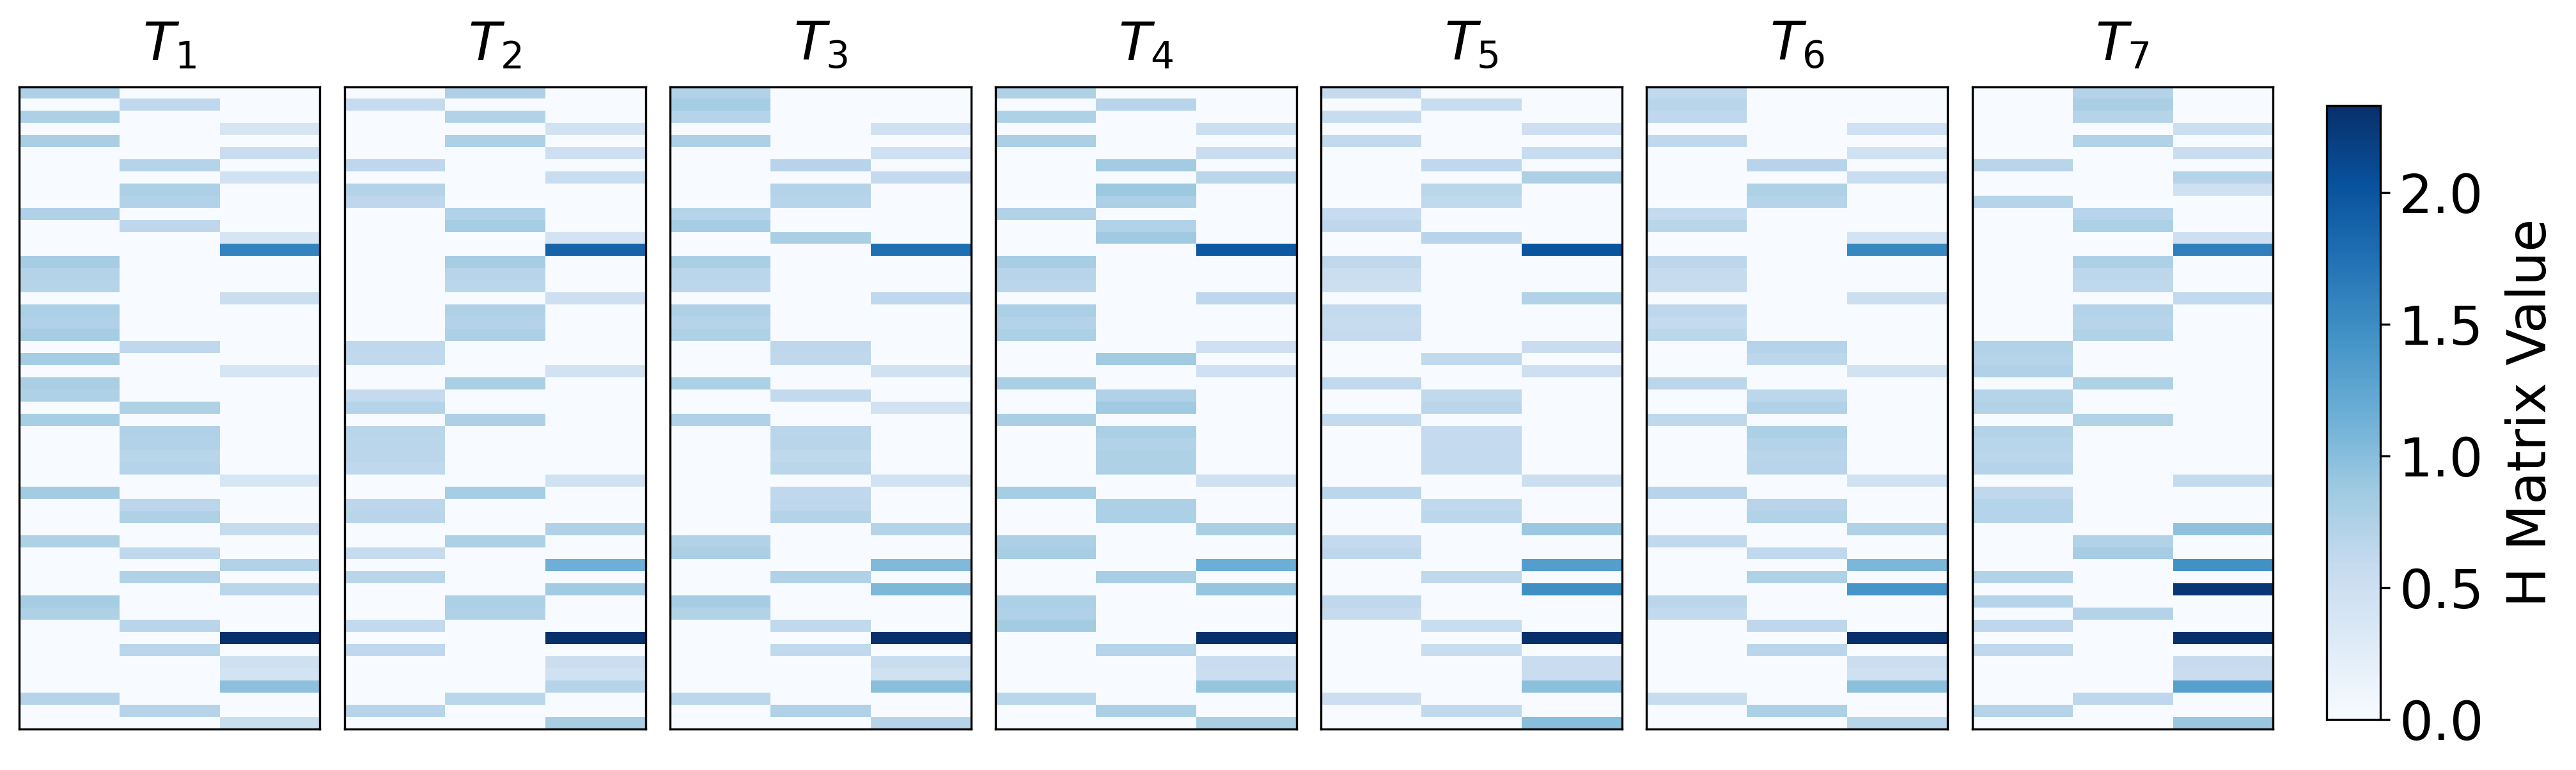

In [8]:
# Set up 1x7 subplots
fig, axes = plt.subplots(1, 7, figsize=(14, 4), dpi=300)

# Store images for color bar scaling
ims = []  

# Iterate through each constrained H matrix and plot it
for i in range(7):
    ax = axes[i]
    im = ax.imshow(H_matrices_constrained[i], cmap="Blues", aspect="auto", interpolation="nearest")
    ims.append(im)  # Store for color bar

    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False)

    # Add title for each subplot (T1, T2, ..., T7)
    ax.set_title(r"$\mathit{T_" + str(i+1) + "}$", fontsize=20, fontweight='bold', style='italic', pad=10)

# Adjust layout for better spacing
plt.tight_layout()

# Add a smaller color bar outside
fig.subplots_adjust(right=0.85)  # Make space for the color bar
cbar_ax = fig.add_axes([0.87, 0.05, 0.02, 0.8])  # Smaller and centered color bar
cbar = plt.colorbar(ims[-1], cax=cbar_ax)
cbar.set_label("H Matrix Value", fontsize=20, labelpad=8)
cbar.ax.tick_params(labelsize=20)

# Save the figure (optional)
plt.savefig("H_matrices_constrained_plot.png", dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

In [9]:
Py_array_constrained

array([[0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679]])